<a href="https://colab.research.google.com/github/shshojaei/research-of-super-resolution/blob/main/EDSR_my_ssim_luminance_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://keras.io/examples/vision/edsr/



In [ ]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/MyDrive/Colab Notebooks/EDSR'

Mounted at /content/drive
my_mae	my_mse	my_ssim_luminance_main	my_ssim_luminance_psnr


## **Imports**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg19 import VGG19
from keras.models import Sequential

AUTOTUNE = tf.data.AUTOTUNE #for data augmentation

## **prepare dataset**

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()
    

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete20XVUF/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete20XVUF/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## **image pre-processing**


*   batch size



In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    hight resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [ ]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [ ]:
#visualize a few sample images

lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

## **architecture** (method)


*   scale



In [ ]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

In [ ]:
# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [ ]:
model.summary()

Model: "edsr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['rescaling[0][0]']              
                                64)                                                      

## **Training**


*   Optimizer
*   learning rate
*   loss function
*   epochs



In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optimizer_ = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

In [ ]:
import keras.backend as K

def my_mae(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.abs(y_pred - y_true), axis=-1)


In [ ]:
import keras.backend as K

def my_mse(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.9 MB/s 


In [ ]:
import keras.backend as K
import tensorflow_addons as tfa

def my_ssim_luminance_main(y_true, y_pred):
  #source: https://www.tensorflow.org/addons/api_docs/python/tfa/image/gaussian_filter2d
  #Means obtained by Gaussian filtering of inputs => source: https://www.programcreek.com/python/?CodeExample=compute+ssim
  y_true = tfa.image.gaussian_filter2d(y_true, filter_shape=(11,11), sigma=1.5) #input and output is a Tensor
  y_pred = tfa.image.gaussian_filter2d(y_pred, filter_shape=(11,11), sigma=1.5)

  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float64')
  y_pred = K.cast( y_pred, 'float64')

  # k1 & c1 depend on L (width of color map)
  l = 255
  k_1 = 0.01
  c_1 = (k_1 * l)**2

  # Squares of means
  mu_1_sq = y_true**2
  mu_2_sq = y_pred**2
  mu_1_mu_2 = y_true * y_pred

  ssim_map = (2 * mu_1_mu_2 + c_1) / (mu_1_sq + mu_2_sq + c_1)

  # return MSSIM
  index = K.mean(ssim_map)

  return index 

In [ ]:
def PSNR(super_resolution, high_resolution):
  #Compute the peak signal-to-noise ratio, measures quality of image.
  # Max value of pixel is 255
  psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
  return psnr_value

In [ ]:
#source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint'
STEPS_PER_EPOCH = 200

#Create a callback that saves the model's weights every 10 epochs 
#source: https://stackoverflow.com/questions/59069058/save-model-every-10-epochs-tensorflow-keras-v2

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_freq= int(10 * STEPS_PER_EPOCH)
)

In [ ]:
model.compile(optimizer=optimizer_ , loss=my_ssim_luminance_main , metrics=[PSNR])

# Training for more epochs will improve results
history_my_ssim_luminance_main = model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100
200/200 [==============================] - 96s 337ms/step - loss: -0.9225 - PSNR: 0.7369 - val_loss: -0.9566 - val_PSNR: 1.6055
Epoch 2/100
200/200 [==============================] - 9s 44ms/step - loss: -0.9495 - PSNR: 0.9713 - val_loss: -0.9546 - val_PSNR: 0.3627
Epoch 3/100
200/200 [==============================] - 9s 44ms/step - loss: -0.9583 - PSNR: 1.7310 - val_loss: -0.9681 - val_PSNR: 0.5710
Epoch 4/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9580 - PSNR: 1.4219 - val_loss: -0.9622 - val_PSNR: 1.4569
Epoch 5/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9612 - PSNR: 1.9606 - val_loss: -0.9681 - val_PSNR: 1.2417
Epoch 6/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9576 - PSNR: 1.6308 - val_loss: -0.9682 - val_PSNR: 1.3877
Epoch 7/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9598 - PSNR: 1.8913 - val_loss: -0.9674 - val_PSNR: 1.9993
Epoch 8/100
200/200 [===========

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 13s 65ms/step - loss: -0.9609 - PSNR: 1.1466 - val_loss: -0.9516 - val_PSNR: 2.8504
Epoch 11/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9613 - PSNR: 1.9347 - val_loss: -0.9705 - val_PSNR: 3.0678
Epoch 12/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9635 - PSNR: 1.6769 - val_loss: -0.9557 - val_PSNR: 1.3562
Epoch 13/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9632 - PSNR: 1.6839 - val_loss: -0.9606 - val_PSNR: 1.5248
Epoch 14/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9687 - PSNR: 1.8623 - val_loss: -0.9674 - val_PSNR: 1.3872
Epoch 15/100
200/200 [==============================] - 8s 38ms/step - loss: -0.9651 - PSNR: 2.4234 - val_loss: -0.9600 - val_PSNR: 0.2291
Epoch 16/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9658 - PSNR: 2.2168 - val_loss: -0.9705 - val_PSNR: 0.6527
Epoch 17/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: -0.9608 - PSNR: 1.7008 - val_loss: -0.9622 - val_PSNR: 1.4114
Epoch 21/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9633 - PSNR: 1.2590 - val_loss: -0.9620 - val_PSNR: 0.5378
Epoch 22/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9655 - PSNR: 1.8076 - val_loss: -0.9737 - val_PSNR: 2.2520
Epoch 23/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9608 - PSNR: 1.7409 - val_loss: -0.9753 - val_PSNR: -0.4014
Epoch 24/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9666 - PSNR: 1.7288 - val_loss: -0.9647 - val_PSNR: 4.3242
Epoch 25/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9662 - PSNR: 1.6436 - val_loss: -0.9765 - val_PSNR: 3.1915
Epoch 26/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9668 - PSNR: 2.1225 - val_loss: -0.9785 - val_PSNR: 2.6211
Epoch 27/100
200/200 [================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9682 - PSNR: 1.7587 - val_loss: -0.9746 - val_PSNR: 1.6807
Epoch 31/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9673 - PSNR: 1.8767 - val_loss: -0.9593 - val_PSNR: 0.3912
Epoch 32/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9676 - PSNR: 1.4920 - val_loss: -0.9621 - val_PSNR: 1.1828
Epoch 33/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9652 - PSNR: 2.2068 - val_loss: -0.9787 - val_PSNR: 1.4847
Epoch 34/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9684 - PSNR: 1.7778 - val_loss: -0.9732 - val_PSNR: 0.2104
Epoch 35/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9652 - PSNR: 1.7318 - val_loss: -0.9697 - val_PSNR: 2.6632
Epoch 36/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9686 - PSNR: 2.3561 - val_loss: -0.9711 - val_PSNR: 1.1706
Epoch 37/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9680 - PSNR: 1.7206 - val_loss: -0.9677 - val_PSNR: 0.8923
Epoch 41/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9638 - PSNR: 1.3227 - val_loss: -0.9667 - val_PSNR: 3.4115
Epoch 42/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9669 - PSNR: 1.2174 - val_loss: -0.9664 - val_PSNR: 2.9689
Epoch 43/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9690 - PSNR: 1.6963 - val_loss: -0.9673 - val_PSNR: 3.4146
Epoch 44/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9696 - PSNR: 2.0730 - val_loss: -0.9391 - val_PSNR: 0.6838
Epoch 45/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9691 - PSNR: 2.2868 - val_loss: -0.9648 - val_PSNR: 2.5195
Epoch 46/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9685 - PSNR: 1.7269 - val_loss: -0.9712 - val_PSNR: 3.0152
Epoch 47/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 13s 64ms/step - loss: -0.9653 - PSNR: 2.1753 - val_loss: -0.9643 - val_PSNR: 2.2285
Epoch 51/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9688 - PSNR: 1.8046 - val_loss: -0.9734 - val_PSNR: 3.2057
Epoch 52/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9710 - PSNR: 1.8844 - val_loss: -0.9695 - val_PSNR: 1.7075
Epoch 53/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9692 - PSNR: 1.9838 - val_loss: -0.9704 - val_PSNR: 1.6727
Epoch 54/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9688 - PSNR: 1.9884 - val_loss: -0.9765 - val_PSNR: 3.6938
Epoch 55/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9699 - PSNR: 1.9917 - val_loss: -0.9691 - val_PSNR: 1.9219
Epoch 56/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9682 - PSNR: 1.7984 - val_loss: -0.9785 - val_PSNR: 4.0847
Epoch 57/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9705 - PSNR: 1.4724 - val_loss: -0.9580 - val_PSNR: 3.3806
Epoch 61/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9674 - PSNR: 1.6019 - val_loss: -0.9732 - val_PSNR: 1.0512
Epoch 62/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9702 - PSNR: 1.2969 - val_loss: -0.9716 - val_PSNR: 1.9512
Epoch 63/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9699 - PSNR: 1.7939 - val_loss: -0.9755 - val_PSNR: 3.2433
Epoch 64/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9686 - PSNR: 1.5821 - val_loss: -0.9684 - val_PSNR: 1.5986
Epoch 65/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9696 - PSNR: 1.5309 - val_loss: -0.9702 - val_PSNR: 2.9713
Epoch 66/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9680 - PSNR: 1.7920 - val_loss: -0.9734 - val_PSNR: 3.6543
Epoch 67/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 60ms/step - loss: -0.9679 - PSNR: 2.3098 - val_loss: -0.9668 - val_PSNR: 2.7124
Epoch 71/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9704 - PSNR: 1.8183 - val_loss: -0.9547 - val_PSNR: 3.4635
Epoch 72/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9681 - PSNR: 1.8173 - val_loss: -0.9574 - val_PSNR: 1.1764
Epoch 73/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9680 - PSNR: 1.4465 - val_loss: -0.9579 - val_PSNR: -0.2037
Epoch 74/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9684 - PSNR: 1.5964 - val_loss: -0.9790 - val_PSNR: 0.8784
Epoch 75/100
200/200 [==============================] - 8s 38ms/step - loss: -0.9683 - PSNR: 1.1424 - val_loss: -0.9694 - val_PSNR: 0.4131
Epoch 76/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9692 - PSNR: 1.7371 - val_loss: -0.9726 - val_PSNR: 4.1906
Epoch 77/100
200/200 [================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9708 - PSNR: 1.5731 - val_loss: -0.9594 - val_PSNR: 1.1321
Epoch 81/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9693 - PSNR: 1.9387 - val_loss: -0.9779 - val_PSNR: 2.0120
Epoch 82/100
200/200 [==============================] - 7s 37ms/step - loss: -0.9675 - PSNR: 2.0456 - val_loss: -0.9647 - val_PSNR: 2.6966
Epoch 83/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9689 - PSNR: 1.8504 - val_loss: -0.9759 - val_PSNR: 0.1826
Epoch 84/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9703 - PSNR: 2.1963 - val_loss: -0.9622 - val_PSNR: 0.6705
Epoch 85/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9694 - PSNR: 2.0834 - val_loss: -0.9523 - val_PSNR: 0.0868
Epoch 86/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9675 - PSNR: 1.3665 - val_loss: -0.9688 - val_PSNR: 0.8358
Epoch 87/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9690 - PSNR: 2.2291 - val_loss: -0.9769 - val_PSNR: 1.8916
Epoch 91/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9685 - PSNR: 1.6117 - val_loss: -0.9581 - val_PSNR: 1.8511
Epoch 92/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9698 - PSNR: 1.9030 - val_loss: -0.9792 - val_PSNR: 2.4721
Epoch 93/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9707 - PSNR: 1.8256 - val_loss: -0.9584 - val_PSNR: 1.1837
Epoch 94/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9698 - PSNR: 2.0591 - val_loss: -0.9743 - val_PSNR: 1.1203
Epoch 95/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9667 - PSNR: 1.9635 - val_loss: -0.9696 - val_PSNR: 0.4052
Epoch 96/100
200/200 [==============================] - 7s 36ms/step - loss: -0.9696 - PSNR: 2.1326 - val_loss: -0.9801 - val_PSNR: 0.1537
Epoch 97/100
200/200 [=================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/checkpoint/assets


200/200 [==============================] - 12s 61ms/step - loss: -0.9719 - PSNR: 1.5765 - val_loss: -0.9568 - val_PSNR: 2.6233


In [ ]:
#to continue training from last epoch that saved ?????
#model.load_weights(checkpoint_filepath)

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_main/model_my_ssim_luminance_main.hdf5')

In [ ]:
#model = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/EDSR/model_my_mae.hdf5')

## **plots**

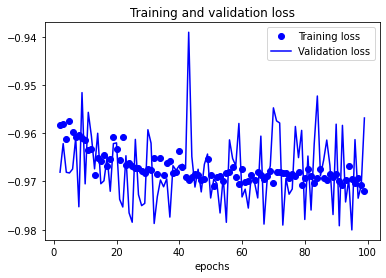

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history_my_ssim_luminance_main.history['loss']
PSNR = history_my_ssim_luminance_main.history['PSNR']
val_loss = history_my_ssim_luminance_main.history['val_loss']
val_PSNR = history_my_ssim_luminance_main.history['val_PSNR']

epochs = range(2,len(loss))

plt.plot(epochs, loss[2:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[2:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()

plt.figure()

plt.show()